# Guia 1

In [30]:
# Imports Generales
from typing import Callable
import numpy as np
from findiff import FinDiff

import matplotlib.pyplot as plt
# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

In [102]:
def plot_colorline(
    t_vals:np.array,
    x_vals: np.array,
    y_vals: np.array,
    cmap_name: str,
    ax: plt.Axes = None,
    **plot_kwargs,
) -> tuple[plt.Axes, plt.cm.ScalarMappable]:
    if ax is None:
        _, ax = plt.subplots(1, 1)
    norm = plt.Normalize(t_vals.min(), t_vals.max(), )
    colormap = plt.cm.ScalarMappable(norm, cmap_name)
    for i, t in enumerate(t_vals[:-1]):
        ax.plot(
            [x_vals[i], x_vals[i+1]],
            [y_vals[i], y_vals[i+1]],
            c=colormap.to_rgba(t),
            alpha=(1-norm(t)+0.5)/1.5,
            lw=(3 - 2*norm(t)),
            **plot_kwargs
        )
    return ax, colormap


def plot_mosaic_phase(
    t: np.array,
    u: np.array,
    v: np.array,
    cmap_name: str,
) -> tuple[plt.Figure, dict[str, plt.Axes]]:
    fig, axs_dict = plt.subplot_mosaic(
        "AAB\n"
        "AAC\n",
        figsize=(7*1.25, 4*1.25),
        constrained_layout=True,
    )

    _, colormap = plot_colorline(t, u, v, cmap_name, ax=axs_dict["A"])
    axs_dict["A"].set_xlabel(r"$x = u$")
    axs_dict["A"].set_ylabel(r"$\dot{x} = v$")
    axs_dict["A"].set_aspect("equal")
    plt.colorbar(colormap, ax=axs_dict["A"], label="$t$", location="right")

    plot_colorline(t, t, u, cmap_name, ax=axs_dict["B"])
    axs_dict["B"].set_xticklabels([])
    axs_dict["B"].yaxis.tick_right()
    axs_dict["B"].yaxis.set_label_position("right")
    axs_dict["B"].set_ylabel(r"$x = u$", )

    plot_colorline(t, t, v, cmap_name, ax=axs_dict["C"])
    axs_dict["C"].set_xlabel(r"$t$")
    axs_dict["C"].yaxis.tick_right()
    axs_dict["C"].yaxis.set_label_position("right")
    axs_dict["C"].set_ylabel(r"$\dot{x} = v$")
    return fig, axs_dict

## Ejercicio 1: Oscilador de van der pol

El oscilador de Van der Pol fue propuesto originalmente por el ingeniero eléctrico y físico holandés Balthasar van der Pol cuando trabajaba en Philips. Van der Pol descubrió oscilaciones estables, que posteriormente denominó oscilaciones de relajación y que ahora se conocen como un tipo de ciclo límite, en circuitos eléctricos que emplean tubos de vacío. Cuando estos circuitos se conducen cerca del ciclo límite, se arrastran, es decir, la señal de conducción arrastra la corriente con ella. Van der Pol y su colega, van der Mark, publicaron en  Nature que a determinadas frecuencias de accionamiento se oía un ruido irregular, que más tarde se descubrió que era el resultado de un caos determinista. ([Van der Pol, 1927](https://doi.org/10.1038%2F120363a0))

La ecuación de Van der Pol tiene una larga historia de uso tanto en las ciencias físicas como en las biológicas. Por ejemplo, en biología, Fitzhugh y Nagumo extendieron la ecuación en un campo plano como modelo para los potenciales de acción de las neuronas. La ecuación también se ha utilizado en sismología para modelizar las dos placas de una falla geológica y en estudios de fonación para modelizar los osciladores de las cuerdas vocales derecha e izquierda.

La ecuación del oscilador de Van der Pol es:


$$\ddot{x} + \alpha (x^2 - 1 ) \dot{x} + x = 0$$


a) Reescriba la ecuación como una ecuación de primer orden para dos variables $u$ y $v$.

b) En el caso con $\alpha = 0$ encuentre la expresión de la energía (puede hacerlo a partir de la física o como una integral primera de la ecuación). A partir de la energía obtenida anteriormente obtenga la ecuación de balance en el caso general $\left( \frac{dE}{dt} = f(x,\dot{x},t) \right)$.  

c) Escriba un integrador usando el método de Runge-Kutta de cuarto orden como una función que tome como entrada una función $f$ (derivada temporal de $x = (u,v)$), una condición inicial $x_0$ y $\alpha$ y devuelva la evolución.  

d) Integre con las condiciones $\alpha = 0.5 , 1.5$ y $3$ por un tiempo total de $5$. Use la ecuación de balance para elegir un $dt$ que sea bueno para todos los casos (Utilice las funciones que les proveemos. adaptandolas para el caso. Una diferencia de un $\sim 1 \%$ con respecto a la energía inicial es aceptable). Grafique $x(t)$, $\dot{x}(t)$ y el diagrama de fases. ¿Cómo relaciona las trayectorias con el balance en función del tiempo?  Describa qué tipos de movimientos presenta el sistema.

e) Utilice la herramienta _odeint_ de scipy para integrar tanto en las condiciones del punto $c$. Analice la elección de intervalos temporales.

### Respuestas

### a)
Tomando $u=x$ y $v=\dot{x}$, tenemos que:
$$\begin{cases}
    \dot{u}&= v\\
    \dot{v}&=-u-\alpha u^2 v + \alpha v 
  \end{cases}
$$

### b)
Para el caso $\alpha=0$ podemos calcular la energía mecánica $E = T + V$ dónde $T = \dot{x}^2/2$ y $V$ es tal que $F = - \frac{\mathrm{d} V}{\mathrm{d} x}$ con $F = - x$ de manera que $V = x^2/2$. Así, se tiene:
$$E = \frac{\dot{x}^2}{2} + \frac{x^2}{2}$$
Luego derivando respecto de $t$ y reemplazando $\ddot{x}$ por su valor según a la ecuación original se tiene:
$$\frac{\mathrm{d} E}{\mathrm{d} t} = -\alpha x^2 \dot{x}^2 + \alpha \dot{x}^2$$

### c)

In [61]:

def van_der_pol_func(t, x: tuple[float, float], alpha: float) -> float:
    u, v = x
    return (v, -u - alpha * v * (u**2) + alpha * v)


def runge_kutta_4_step(
    f: Callable,
    x_i: np.array,
    t_i: float,
    dt: float,
    *args,
) -> np.array:
    k_array = np.empty((4, x_i.size))
    k_array[0] = f(t_i, x_i, *args)
    k_array[1] = f(t_i + dt/2, x_i + dt / 2 * k_array[0], *args)
    k_array[2] = f(t_i + dt/2, x_i + dt / 2 * k_array[1], *args)
    k_array[3] = f(t_i + dt, x_i + dt * k_array[2], *args)
    a_vec = np.array([1, 2, 2, 1])/6
    a_vec = a_vec.reshape((4, 1))
    return x_i + dt*np.sum(a_vec * k_array, axis=0)


def runge_kutta_4(
    f: Callable,
    x_0: np.array,
    t_0: float,
    dt: float,
    steps: int,
    **kwargs,
) -> np.array:
    x_vals = np.zeros((1+steps, x_0.size))
    x_vals[0] = x_0
    for i in range(steps):
        x_vals[i+1] = runge_kutta_4_step(
            f, x_vals[i], t_0+i*dt, dt, *kwargs.values()
        )
    return x_vals

In [65]:
t_0 = 0
x0 = np.array([0.5, 0.5])
total_time = 20
dt = 0.01
time_values = np.arange(0, total_time, dt)
u, v = runge_kutta_4(van_der_pol_func, x_0=x0, t_0=t_0, dt=dt, steps=int(total_time/dt), alpha=2).T

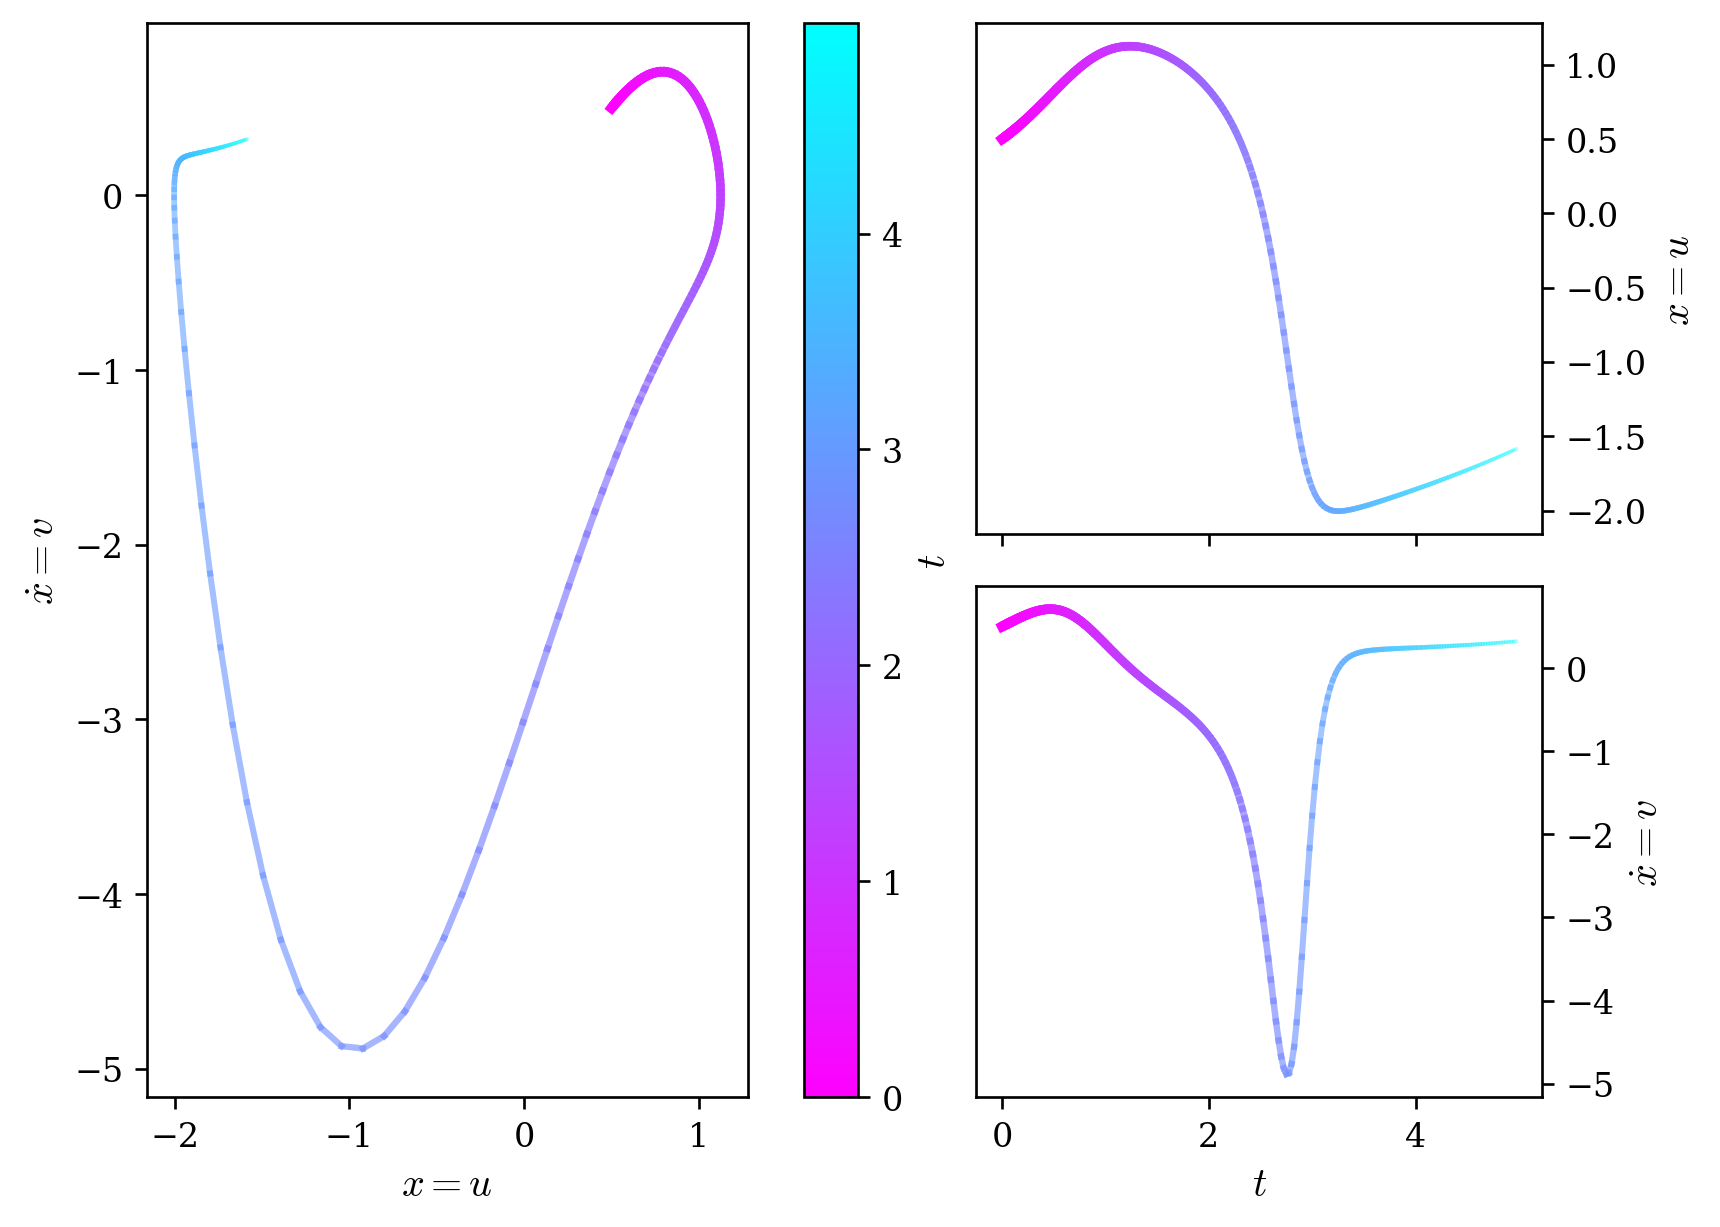

In [103]:
fig, axs_dict = plot_mosaic_phase(time_values, u, v, "cool_r")
plt.show()

### d)

In [55]:
def Energy(u: np.array, v: np.array, *params) -> np.array:
  '''
  Esta función recibe u (x) y v (dx/dt) junto con los parámetros
  de la ecuación y devuelve la expresión de la energía
  '''
  return (u**2 + v**2)/2

def dEdt(u: np.array, v: np.array, *params) -> np.array:
  '''
  Esta función recibe u (x) y v (dx/dt) junto con los parámetros
  de la ecuación y devuelve la teórica de la derivada de la energía
  '''
  return - params[0]*(u**2 - 1)*v**2


def balance(Energy: Callable, dEdt: Callable, u: np.array, v: np.array, dt: float, *params):
  '''
  Esta función recibe u (x), v (dx/dt), parametros extra y
  las funciónes de la energía y su derivada. Devuelve un vector
  de balance que tiene la diferencia de la energía del sistema
  en cada tiempo con respecto al valor teórico normalizado por
  el valor inicial de la energía.
  '''
  d_dt = FinDiff(0, dt, acc=6)
  E = Energy(u, v, *params)
  dE   = d_dt(E)
  dEt  = dEdt(u,v, *params)
  return dt * (dE - dEt)/E[0]#np.min(E)

In [90]:
t_0 = 0
x0 = np.array([0.5, 0.5])
total_time = 5
balance_tolelance = 0.01
res_dict = {0.5: None, 1.5: None, 3: None}
for alpha in [0.5, 1.5, 3]:
    dt = 0.1
    while res_dict[alpha] is None:
        time_values = np.arange(0, total_time, dt)
        u, v = runge_kutta_4(van_der_pol_func, x_0=x0, t_0=t_0, dt=dt, steps=int(total_time/dt), alpha=alpha).T
        config_balance = balance(Energy, dEdt, u, v, dt, alpha)
        if (np.abs(config_balance) < balance_tolelance).all():
            # print(alpha, dt, np.abs(config_balance).max())
            res_dict[alpha] = (time_values, u, v, dt)
        else:
            dt /= 2
        

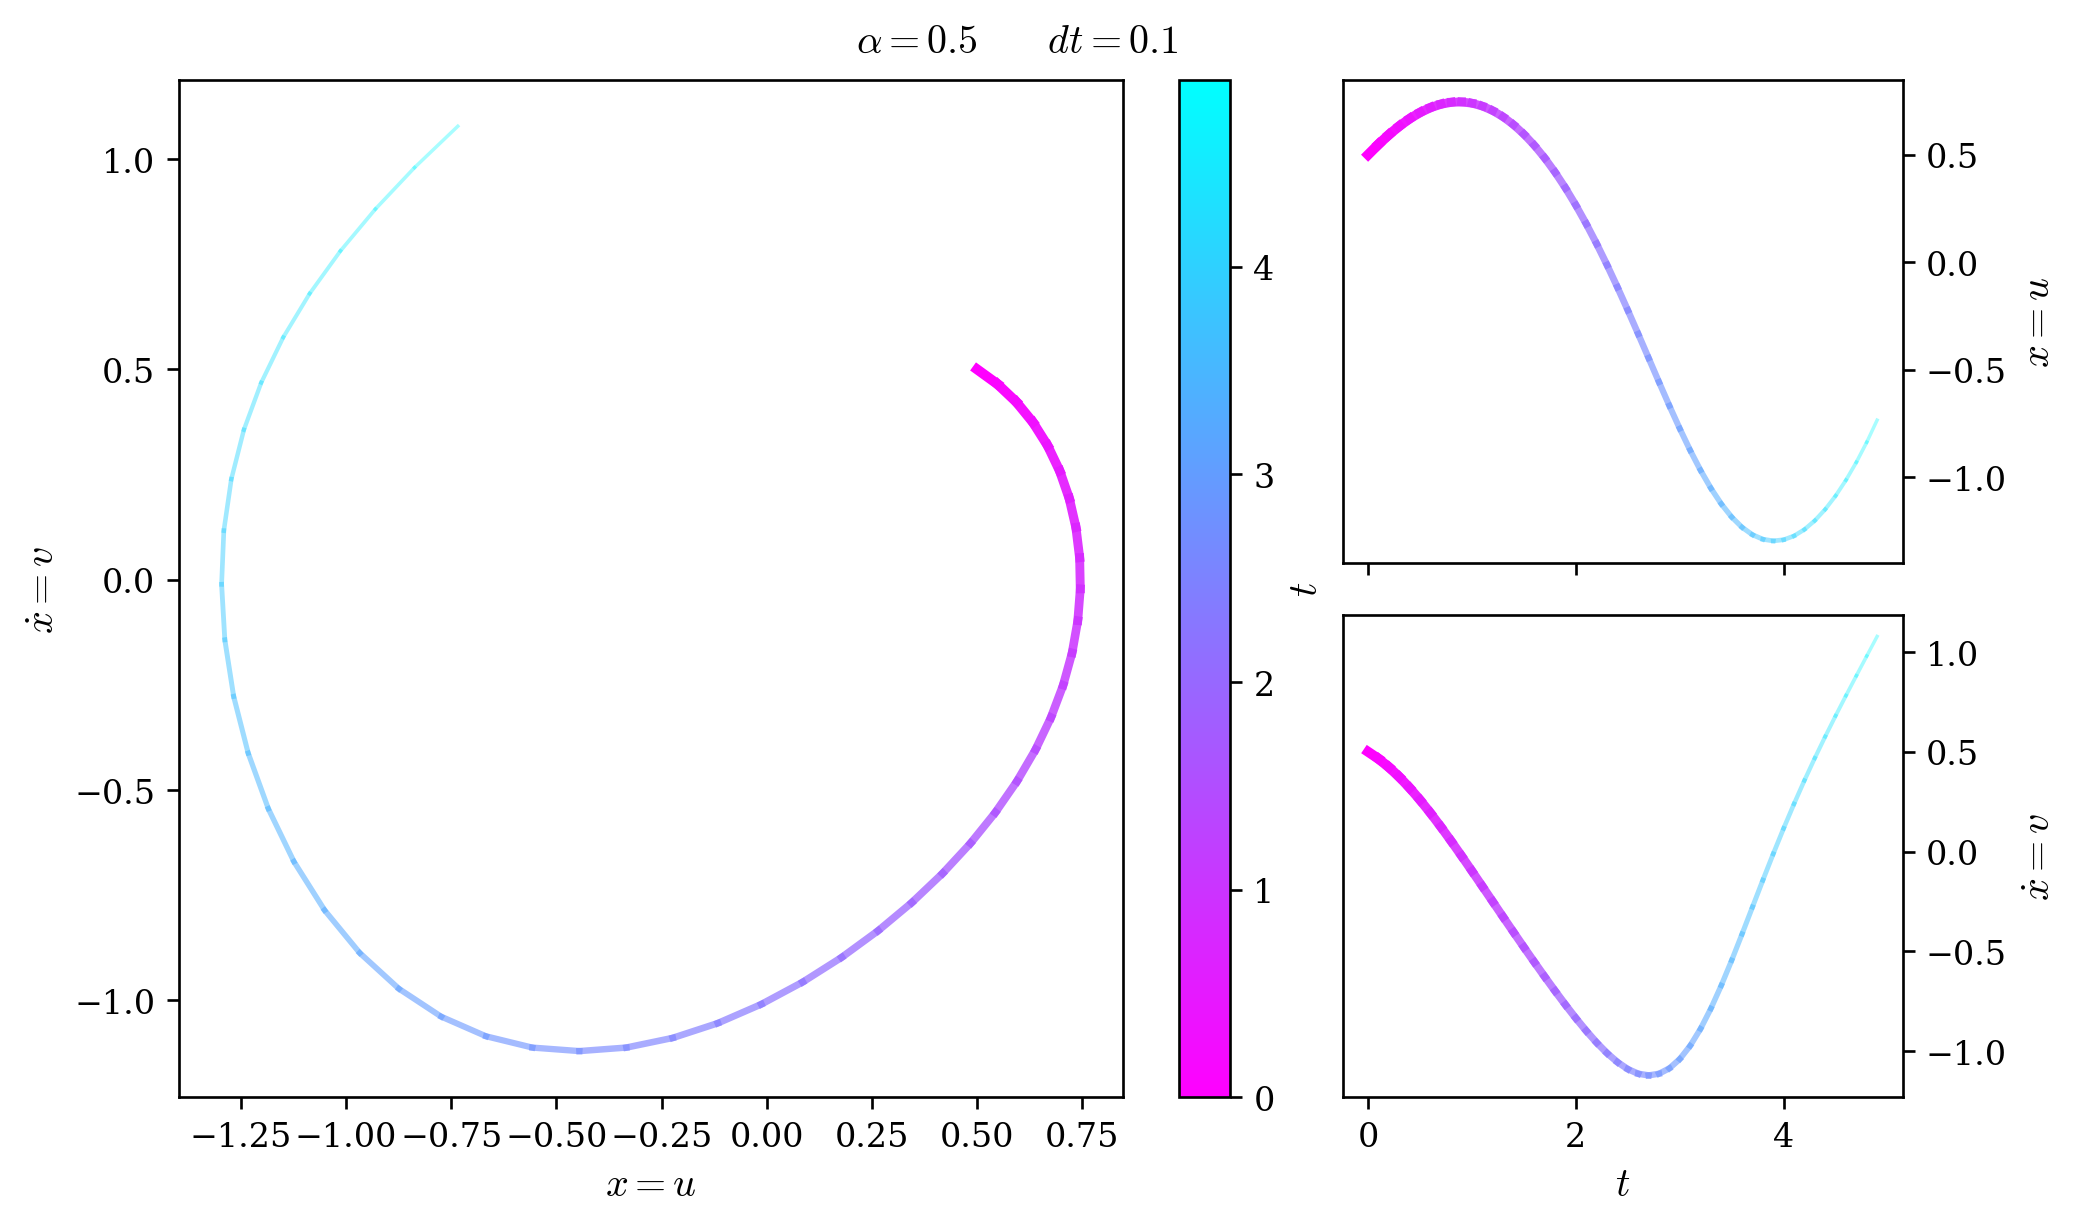

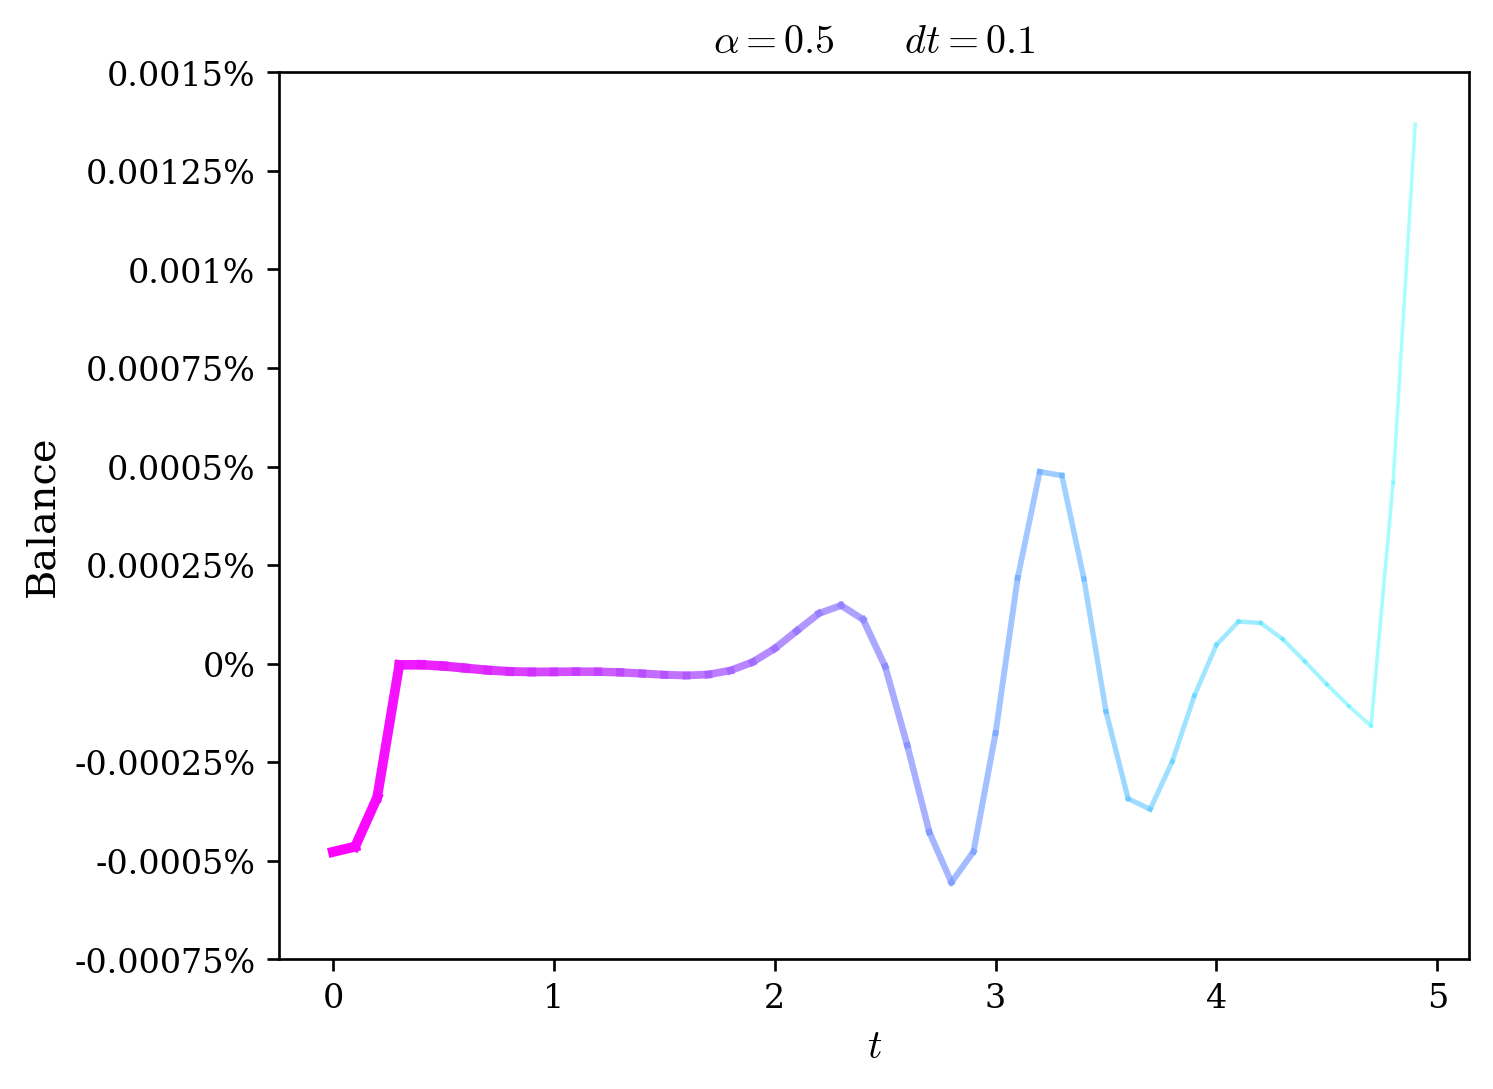

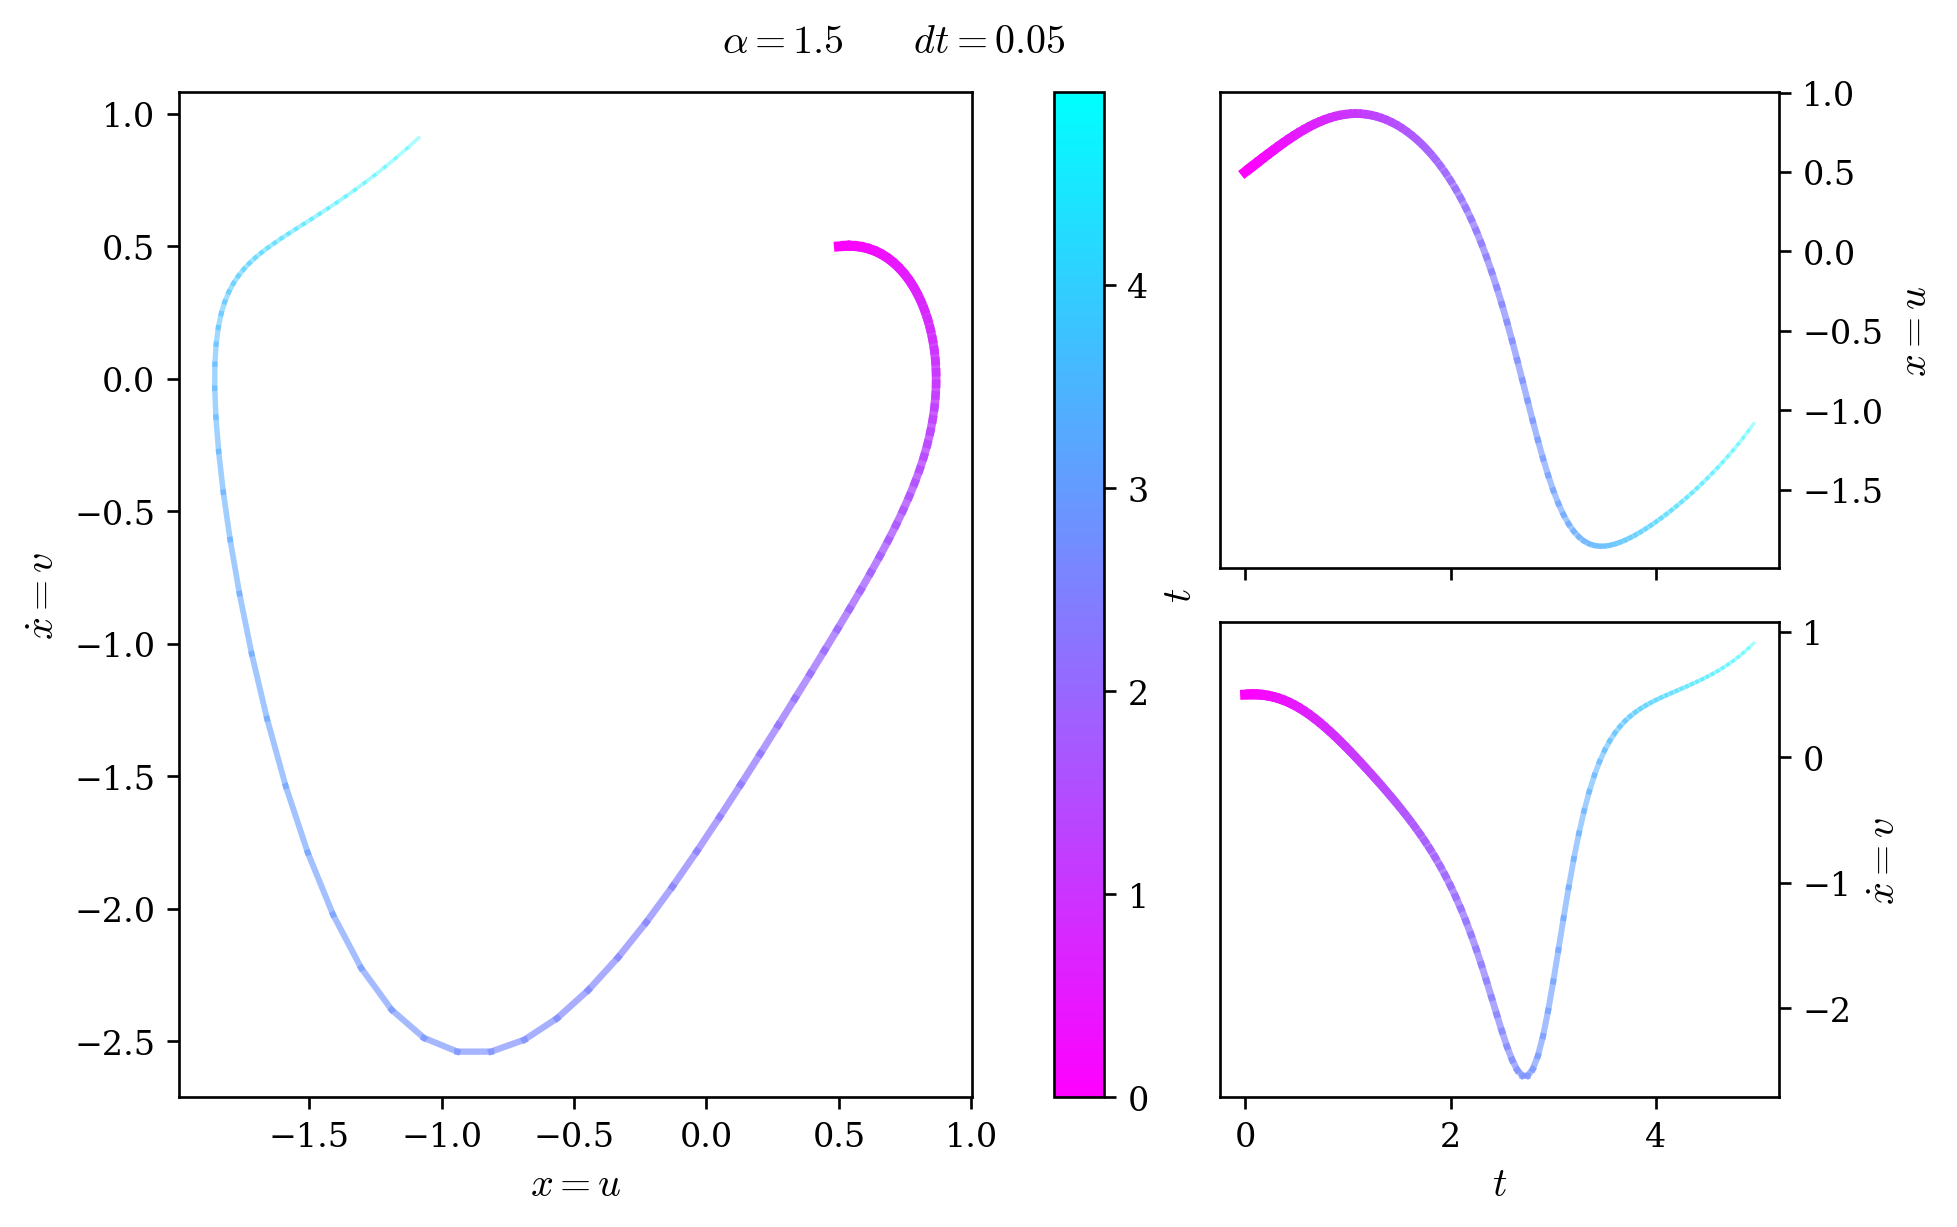

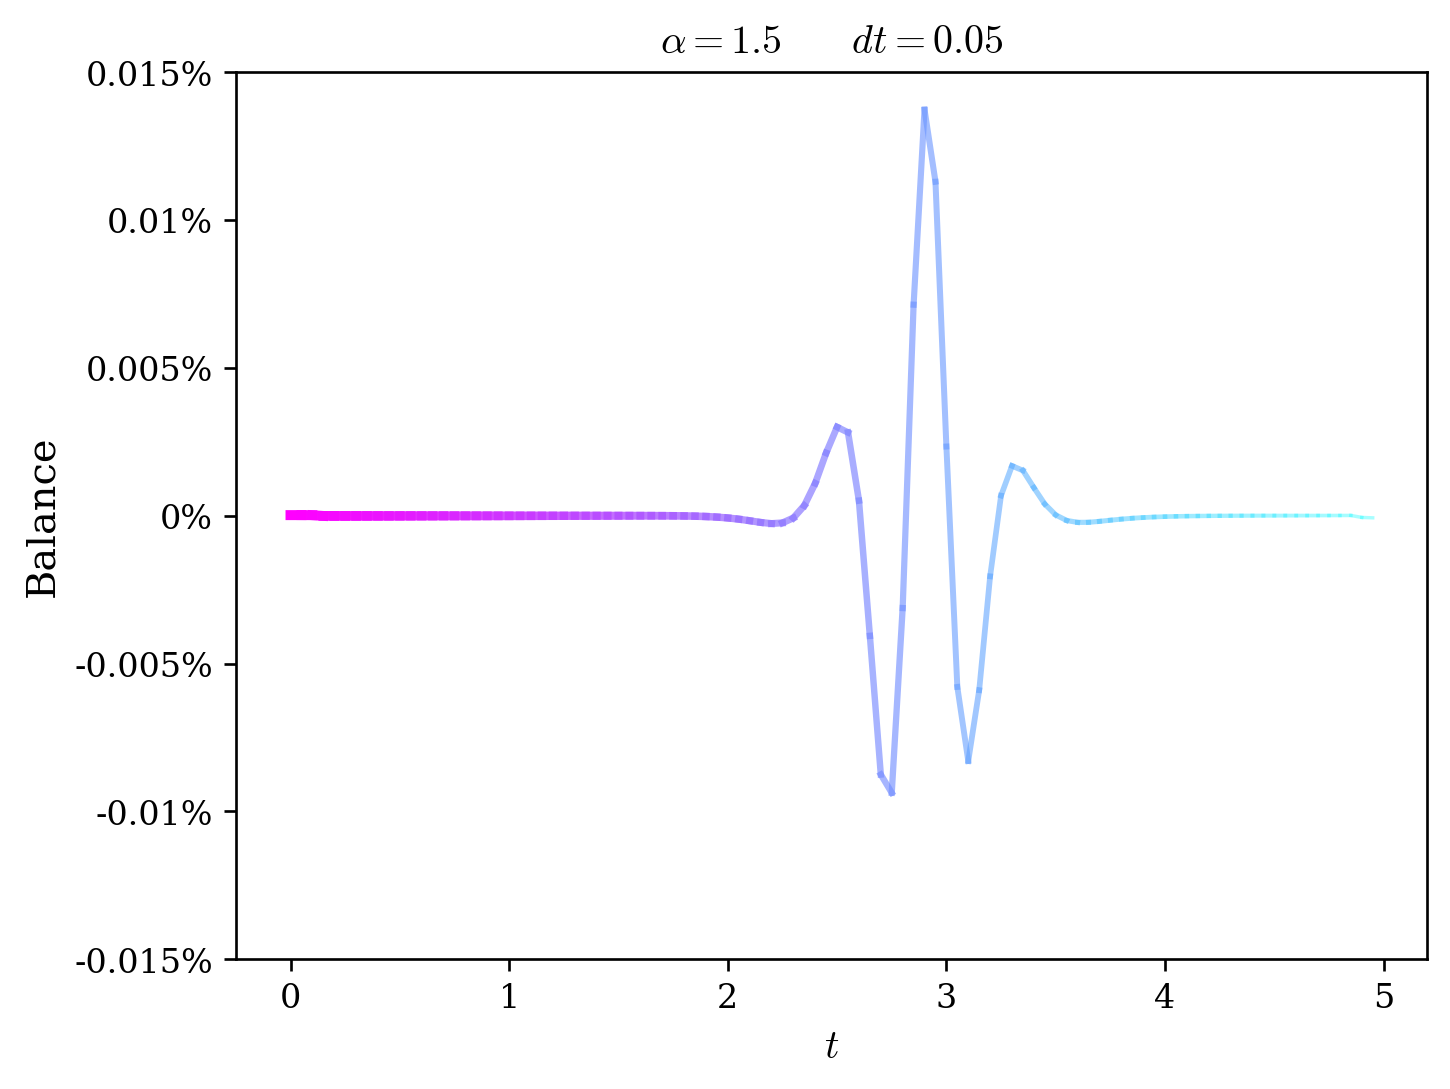

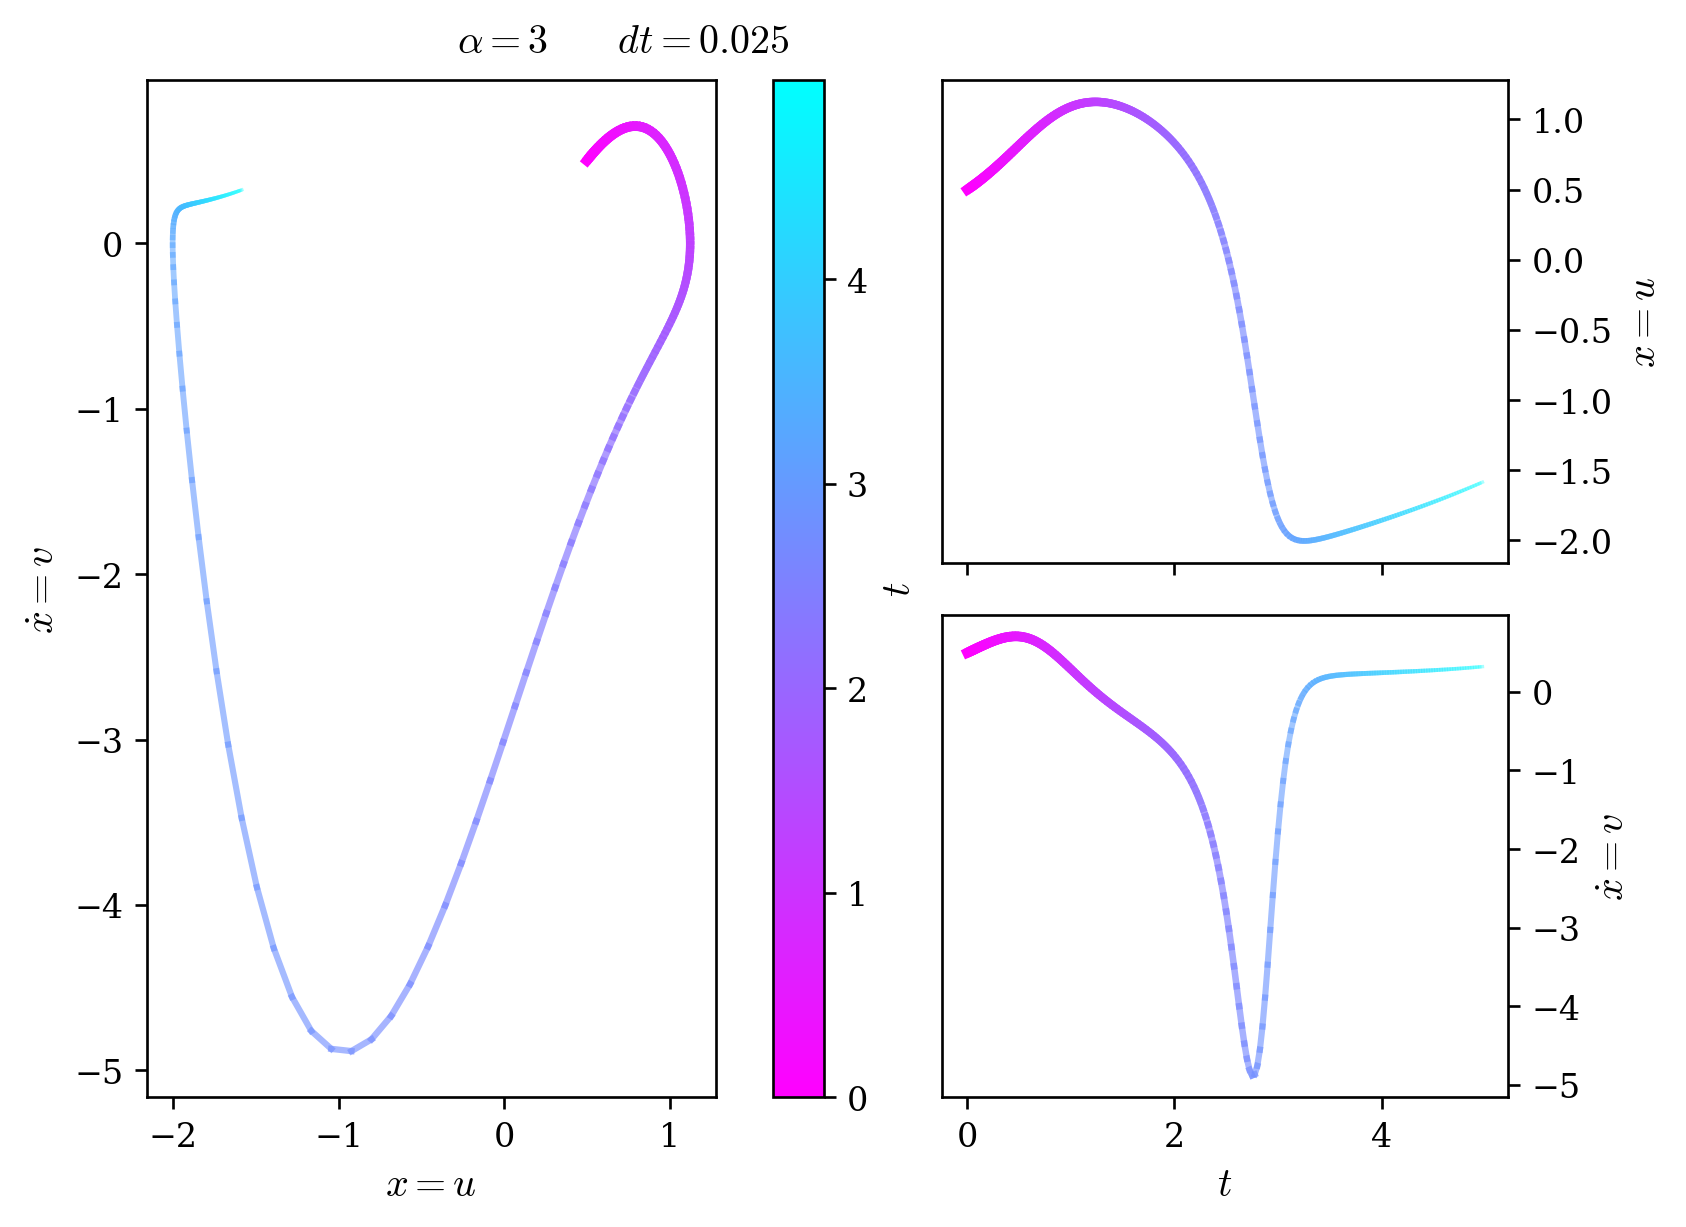

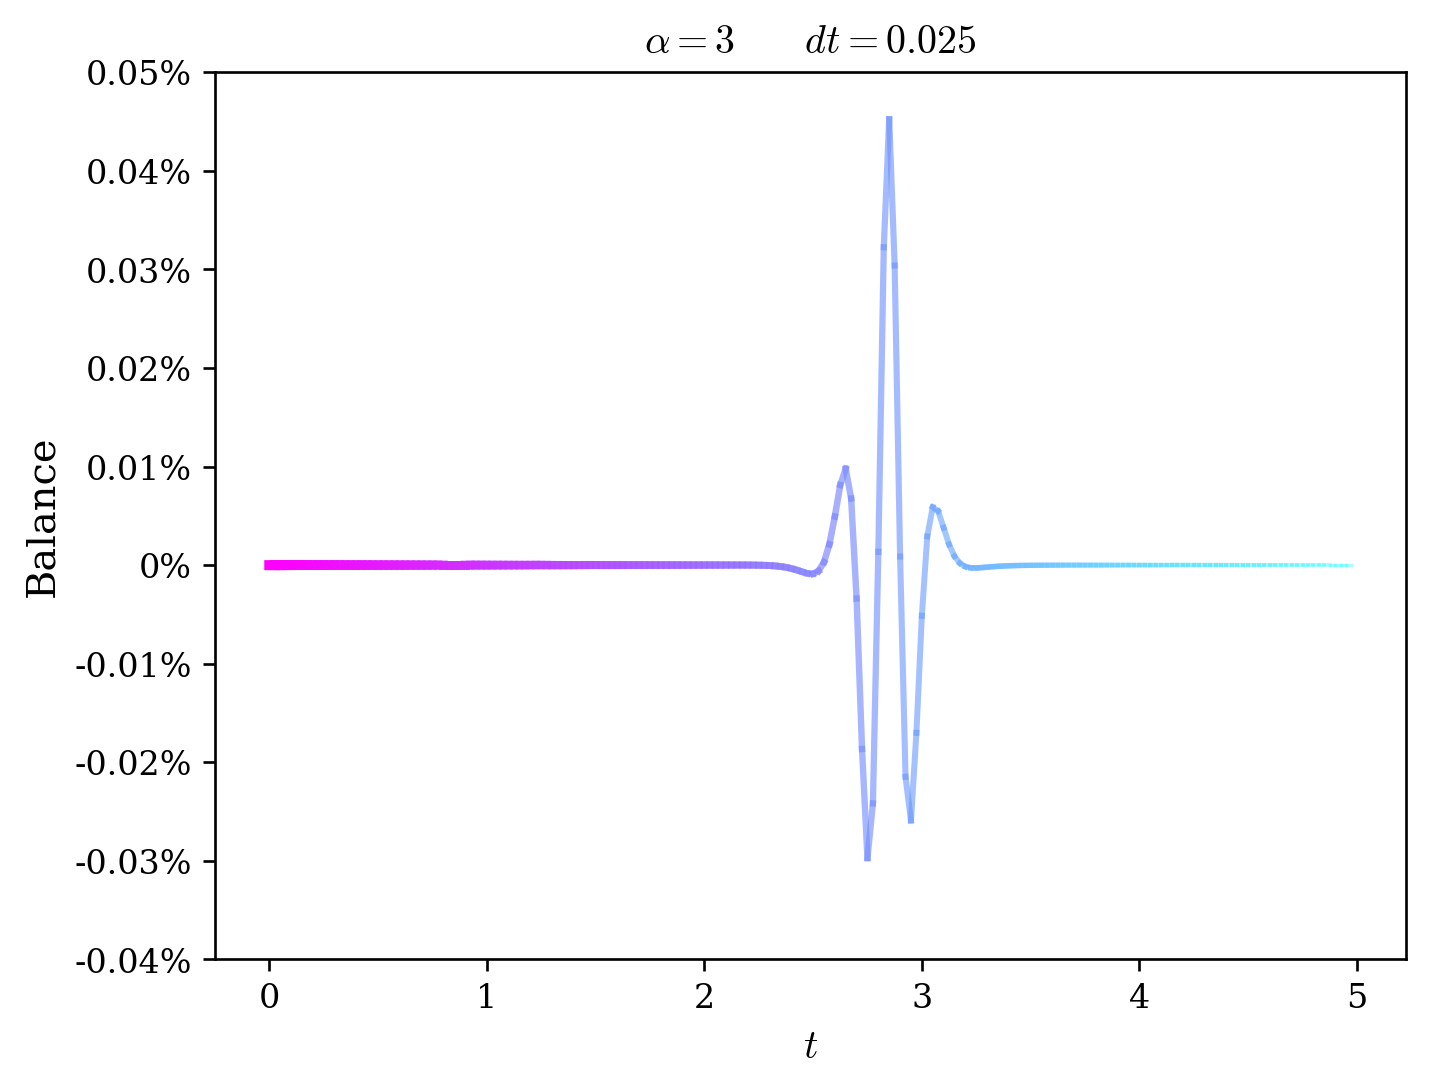

In [105]:
for alpha, results in res_dict.items():
    t, u, v, dt = results
    fig, axs_dict = plot_mosaic_phase(t, u, v, "cool_r")
    fig.suptitle(rf"$\alpha = {alpha} \qquad dt = {dt}$")
    plt.show()
    
    ax, colormap = plot_colorline(t, t, balance(Energy, dEdt, u, v, dt, alpha), "cool_r")
    ax.set_title(rf"$\alpha = {alpha} \qquad dt = {dt}$")
    # ax.axhline(0.01, ls="--", lw=1, c="k")
    # ax.axhline(-0.01, ls="--", lw=1, c="k")
    ax.set_xlabel("$t$")
    ax.set_ylabel("Balance")
    yticks = ax.get_yticks()
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{val*100:.3g}%" for val in yticks])
    plt.show()

## Ejercicio 2: Oscilador de Duffing

El oscilador de Duffing, llamado así a partir de Georg Duffing (1861–1944) es una ecuación diferencial de segundo orden que sirve para modelar osciladores forzados y amortiguados.

$$\ddot{x}+\delta \dot{x}+ \beta x+ \alpha x^3=\gamma \cos (\omega t)$$


Donde:


*   $\delta$ es que tan intenso es el amortiguamiento
*   $\alpha$ la dureza del "resorte" ($k/m$ que utilizamos normalmente)
*   $\beta$ es el parámetro no lineal. Si $\beta = 0$ tenemos un resorte con amortiguamiento normal. Si $\beta>0$ es un resorte endurecido y $\beta<0$ uno ablandado
*   $\gamma$ es la amplitud del forzado
*   $\omega$ es la amplitud del forzado

a) Reescriba la ecuación como un sistema de primer orden para dos variables $(u,v)$.

b) Para el caso sin forzado y disipativo encuentre la expresión de la energía. Encuentre los puntos de equilibrio del sistema en función de los parámetros. Calcule la derivada de la energía (dada la definición anterior) en función del tiempo en el caso general para obtener la ecuación de balance.

c) Escriba un integrador usando Runge-Kutta de cuarto orden (llamelo RK4_duffing) que tome como entrada una función $f$ (derivada temporal de $x = (u,v)$), una condición inicial $x_0$ y los parámetros de la ecuación y devuelva la evolución.

d) Usando $\alpha = 1$, $\beta  =  1$, $\gamma =  0$ y  $\delta =  0$, integre la ecuación por un tiempo $T=20$ para varias condiciones iniciales. Use la conservación de la energía para elegir un paso temporal tal que esta se conserve.

e) Ahora integre eligiendo condiciones iniciales convenientemente tal que, al graficar las trayectorias juntas, representen bien el diagrama de fases (Sugerencia: marque los puntos de equilibrio y que hayan trayectorias alrededor). Compare con el caso $\alpha = 1$, $\beta  =  -1$, $\gamma =  0$,  $\delta =  0$. ¿Qué tipo de bifurcación encuentra?

f) Repita el punto anterior usando $\delta =  0.1$. ¿Es necesario modificar el dt que eligió o realizar un estudio con la ecuación de balance? Justifique.

g) Repita el punto (e) usando $\delta = 0.22$, $\omega=1$ y $\gamma = 0.3$. Describa lo que encuentra.

h) (Opcional) Integre con los parámetros del punto anterior con $\gamma=0$. Ahora use $\gamma=0.3$, aumente progresivamente la frecuencia del forzado. Describa lo que encuentra. (Pista: Estamos viendo evidencia _averaging theorem_)



a) Celda para realizar el punto a

In [ ]:
#Celda para funciones

## Ejercicio 3: Sistema de Lorenz

Consideremos el sistema de Lorenz ()


$$ \dot{x} = \sigma (y-x) \\
\dot{y} = \rho x - y - xz \\
\dot{z} = xy - \beta z$$

donde $x$, $y$ y $z$ son funciones que dependen del tiempo.

a) Para valores de $\beta=8/3$, $\sigma=10$ y $\rho = 25$ integre utilizando odeint por un tiempo $T=50$ usando $dt=10^{-4}$ y con condiciones iniciales $(x_0,y_0,z_0)=(0,0.5,0.5)$. Grafique $z(t)$, $y(t)$ y $z(y)$. Pruebe cambiar valores de $dt$ y compare las trayectorias de cada una de las variables.

Integre usando el siguiente bloque

```Python
solver = scipy.integrate.ode(f).set_integrator('dopri5')
solver.set_initial_value(x0, t=0.0)

i = 0
while solver.successful() and solver.t < tf:
    i += 1
    solver.integrate(solver.t + dt)
    evolution[i,:] = solver.y

```

Este es un integrador de Runge-Kutta 4(5) con pasos temporales variables a partir del error local. Compare con los resultados anteriores. Grafique el caso anterior en el espacio de fases tridimensional. ¿Qué conclusiones obtiene?

b) Integrando como en $c$ y usando $\rho=30$ compare la evolución temporal de $y$ para las condiciones iniciales  $(x_0,y_0,z_0)=(0,0.5,0.5)$ y $(x^´_0,y^´_0,z^´_0)=(0,0.5,0.50001)$. ¿Qué observa?

c) Resuelva numéricamente las ecuaciones de Lorenz con un método de Runge–Kutta de orden 4 (RK4) con paso fijo. Integre las ecuaciones con los mismos parámetros del inciso anterior usando la condición inicial (x0,y0,z0) = (0,0.5,0.5) con (i) el método de RK4 con pasofijo con $\delta t= 0.005$ y (ii) con el método utilizado en el primer inciso. Compare las dos soluciones.Grafique la diferencia absoluta entre las dos soluciones en función del tiempo. ¿Qué ocurre?


In [ ]:
#Celdas para resolver

## Ejercicio 4: Redes Neuronales Informadas por la física (PINNs)


Las redes neuronales informadas por la física (PINN, por sus siglas en inglés) son aproximadores de funciones que permiten utilizan el conocimiento de las leyes físicas que rigen un sistema durante el proceso de aprendizaje. El empleo del conocimiento físico se utiliza como regularización durante el entrenamiento restringiendo a la red y mejorando la precisión en la aproximación de la función deseada ya que ayuda al entrenamiento haciendo más simple.


El paper fundacional de estas es [Raissi, M., P. Perdikaris, and G. E. Karniadakis. “Physics-Informed Neural Networks: A Deep Learning Framework for Solving Forward and Inverse Problems Involving Nonlinear Partial Differential Equations.” Journal of Computational Physics 378 (February 1, 2019): 686–707.](https://doi.org/10.1016/j.jcp.2018.10.045)











Primero vamos a tener que construir un perceptrón multicapa (MLP por sus siglas en ingles). Un MLP es una red neuronal del tipo _feed forward_ (es decir que la información fluye en un solo sentido, desde las neuronas de entrada hacia la salida) que permiten aproximar funciones de $\mathbb{R}^n → \mathbb{R}^m$. Las redes neuronales _feed forward_ son la base de muchas aplicaciones comerciales como credes convolucionales para reconocimiento de imagenes.

Son **redes** porque se representan a través de la composición de funciones. Si, por ejemplo, tenemos tres funciones $f$, $g$ y $h$ entonces podemos hacer la composición de ellas como $h(g(f(x)))$. En ese caso, $f$ es la primera capa, $g$ es la segunda y $h$ la tercera (siendo que es la última se conoce como neurona de salida o output layer). La cantidad de capas que tiene la red determina su *profundidad*. El término **aprendizaje profundo** (Deep learning en inglés) proviene justamente de esto.   

Veamos la estructura de un MLP. Estos poseen una capa de entrada con un número arbitrario de neuronas (numeritos) que va a ser el input para nuestra red. Luego una serie de capas ocultas (la versión más simple posee una sola capa oculta) y por último una capa de salida (donde nosotros esperamos ver el resultado que queremos).


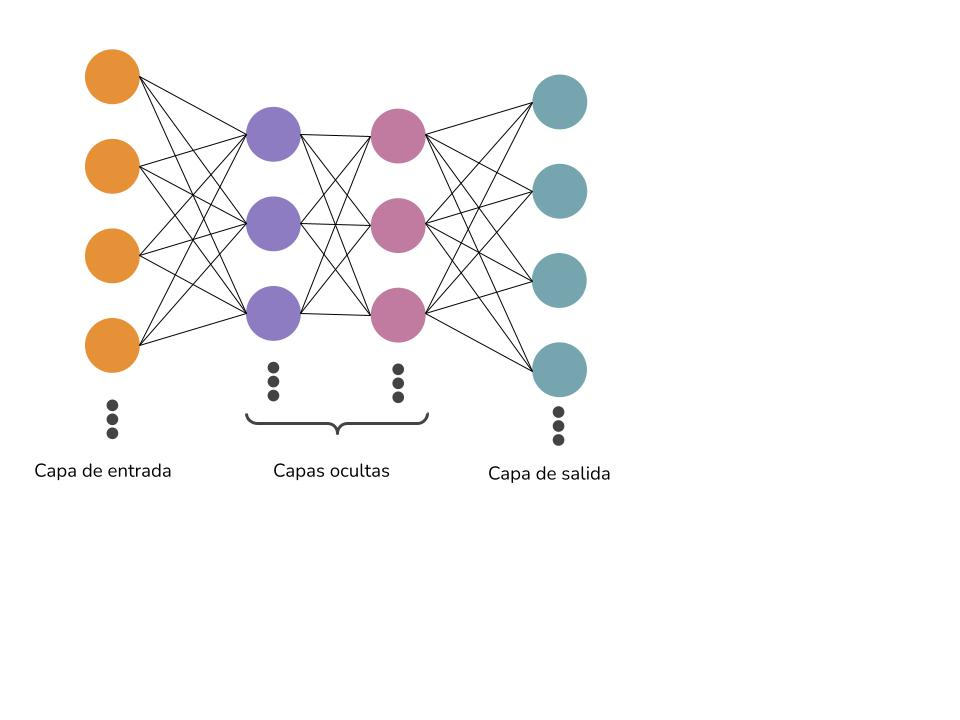

### Construyendo una Red

Centremonos primero en entender como se construye el caso más simple, un perceptrón con una sola capa oculta (también conocido como _shallow_). La entrada a nuestra red serán vectores $x \, \epsilon \, \mathbb{R}^n$, nuestra capa oculta es $h$ y posee $k$ neuronas, y la salida queremos que sea un vector $y \, \epsilon \, \mathbb{R}^m$. En este caso, la capa de entrada y lo que se tiene en la capa oculta va a estar dada por

$$ h_i (\mathbf{x}) = \sigma \left( \left( \sum_j A_{ij} x_j\right)  - b_i \right).$$

o equivalentemente,

$$\mathbf{h}(\mathbf{x}) = \sigma \left( \mathbf{A}  \cdot \mathbf{x}  - \mathbf{b}  \right).$$

$A_{ij}$ es el peso que asignamos que conecta la entrada $x_j$ con la neurona de la capa oculta $h_i$. Entonces, como se ve en la segunda parte de la expresión, podemos construir esto como una matrix $\mathbf{A}$. Se define $\mathbf{b}$ como bias, este contiene el parámetro de activación $b_i$ de cada una de las neuronas. Finalmente $\sigma$ es la función de activación de la capa oculta $h$, la cuál es aplicada lugar a lugar en el vector. De esta forma, dada una entrada $\mathbf{x}$ define la capa oculta como $\mathbf{h}(\mathbf{x})$.

De la misma forma en la que calculamos el valor de la capa oculta a partir de la inicial, obtenemos la salida a partir de nuestra esta última

$$\mathbf{y}(\mathbf{x}) = \sigma_y \left( \mathbf{A}_y  \cdot \mathbf{h}  - \mathbf{b_y}  \right).$$

En este caso, $\sigma_y$ puede ser una función de activación diferente y va a depender fuertemente de cuales son las cualidades de las salidas que deseamos. Nuestra red de una sola capa oculta queda definida como:

$$R(\mathbf{x}) = y \left( h \left( x \right)  \right)$$

De esta manera ya construimos nuestra imagen del _MLP_ más simple que puede construirse.

Las *redes neuronales* se llaman así debido a que están inspiradas en conceptos de neurociencias. Cada elemento de cada capa se asemeja a una neurona debido en el sentido de que recibe input externo y computa su propio valor de activación. La idea del apilamiento de muchas representaciones vectoriales es también una inspiración de la mencionada área.  

### Apilando redes

Para construir un _Perceptrón multicapa profundo_ se componen capas ocultas haciendo que una sea la entrada de la siguiente. Si nombramos $h_k$ a cada una de las capas ocultas, donde $k$ es el número de capa entonces una red con $n$ capas se construye como:

$$ y = y \left( h_n \left( \cdots h_k \left( \cdots h_2 \left( h_1 \left( x \right) \right) \right) \right) \right)$$

Cada una de las capas, dependiendo la dimensión de su entrada y la propia esta determinada por los pesos entre neuronas $A_{ij}^{(k)}$, los bias $b_i^{(k)}$ y la función de activación $\sigma_k$. Todos los parámetros que componen una red (suma de los de cada una de las capas) los llamamos $\mathbf{\theta}$.



### Entonces... ¿Qué puede hacer un MLP?

El **teorema de aproximación universal** ([Hornik _et al_, 1989](https://doi.org/10.1016/0893-6080(89)90020-8); [Cybenko, 1989](https://doi.org/10.1007/BF02551274)) nos garantiza que una red feedforward como las que describimos, con una activación lineal en la capa de salida con una sola capa oculta con cualquier función que cumpla ciertas propiedades (squashing. Ej: tanh) puede aproximar cualquier función continua en un conjunto cerrado y acotado de $\mathbb{R}^n$ (en verdad lo que dice la demostración es para una función medible de Borel de $\mathbb{R}^n$ a $\mathbb{R}^m$) con el error que uno quiera (si se tienen la cantidad de neuronales ocultas necesaria). Además, las derivadas de esta también puede aproximar las de la función de forma arbitrariamente buena ([Hornik, 1990](https://doi.org/10.1016/0893-6080(90)90005-6)).

Cualquier red que posea mayor profundidad puede ser _al menos_ tan buena como una con una sola capa oculta. El secreto esta en que son, en efecto, aún mejores que eso. En muchas circunstancias, el uso de modelos profundos reduce la cantidad de parámetros que se requieren para representar la función y así evitar el error de generalización.

Bajo estos preceptos los perceptrones multicapa pueden usarse para una variedad enorme de problemas, desde reconocimiento de caracteres hasta detección de fraudes.

### Pero... ¿Cómo hacemos que aproxime?

Sabemos a esta altura que nosotros queremos partir de una entrada $\mathbf{x}$ y generar una salida $\hat{y}$. La red es la que, dada la entrada nos va a proveer de la salida. Es decir,

$$\mathbf{x} \xrightarrow{\text{R}(\mathbf{x})} \hat{\mathbf{y}}.$$

En este proceso, propagamos hacia adelante la información a través de las capas de la red hasta tener un resultado.

Nosotros partiremos de un conjunto de datos de pares $(\mathbf{x},\mathbf{y})$ y busca que $R(\mathbf{x}) = \mathbf{y}^* \approx \mathbf{y}$. Este es uno de los tipos más comunes de problemas, conocidos como aprendizaje supervisado. Para que aproxime la función que nosotros deseamos, debemos **entrenar** la red, es decir, adaptar todos los $\mathbf{\theta}$ de tal forma que se minimice una función costo $J(\theta)$ elegida convenientemente. Para realizar esto se utiliza el algoritmo conocido como **back-propagation** ([Rumelhart _et al_](https://doi.org/10.1038/323533a0)) para calcular los gradientes. Este hace el proceso contrario, lleva la información desde el final de la red hacia el principio. El algoritmo de back propagation permite calcular derivadas de una función de forma computacionalmente eficiente.

Una vez que podemos calcular el gradiente podemos obtener $\nabla_\theta J (\theta)$. Con esta expresión podemos utilizar un algoritmo de minimización para llegar al mínimo de $J (\theta)$ para nuestros datos como por ejemplo descenso por gradiente.

### Funciones de costo

Hasta ahora llamamos $J(\theta)$ a la función costo que depende de todos los parámetros de nuestra red. La decisión de la función costo es una parte importante del diseño de una red neuronal. Un ejemplo de función costo que a esta altura de la formación habremos usado más de una vez es el error cuadrático, que es lo que minimizamos al hacer cuadrados mínimos. Este es un ejemplo común en el que, si los datos que tenemos son un vector $\{ x_1, \dots, x_n\}$ como entradas y las respectivas salidas esperadas  $\{ y_1, \dots, y_n\}$ entonces definimos nuestra función objetivo para la red $f(x;\theta)$ como:

$$ J(\theta) = \frac{1}{n} \sum_i |f(x_i;\theta)-y_i|^2 $$

Las funciones que se usan para otros modelos paramétricos suelen ser buenas elecciones para redes neuronales. La función costo permite no solo generar una métrica del desempeño de nuestra red sino también provee la capacidad de regularizar las soluciones de forma que nuestras soluciones cumplan condiciones que queramos.


Pueden ver más detalles de redes neuronales feed forward en el siguiente [capitulo del libro](https://www.deeplearningbook.org/contents/mlp.html) de Ian Goodfellow.

### Pinns

Supongamos que tenemos un sistema físico que está regido por una ecuación diferencial del tipo:

$$u_t+\mathcal{N}[u]=0, x \in \Omega, t \in[0, T]$$

Donde $u(t,x)$ es la ecuación latente que está escondida y queremos averiguar, $\mathcal{N}[\cdot]$ un operador diferencial no lineal, $\Omega$ es un subconjunto de $\mathbb{R}^d$.

Supongamos que, del sistema físico que mencionamos anteriormente, tenemos datos $\{ u(x_1, t_1 ), \dots,  u(x_n, t_n ) \}$ que podemos haber medido. Nuestro objetivo es aproximar $u(t)$ con una red neuronal profunda como las que describimos anteriormente usando estos datos. Este tipo de problemas son a veces conocidos como de asimilación de datos, donde queremos usar los datos experimentales para obtener la solución teórica. El problema esta en que, en muchos casos no tenemos los datos de las condiciones iniciales o el sistema completo en cierto momento, lo cual permitiría hacer una simulación o resolver la ecuación. Un buen ejemplo sería pensar en un fluido dentro de un tubo dentro del cual hay algunos lugares en los que tenemos instrumentos que permiten medir la velocidad y cada uno de ellos lo puede hacer con una cadencia distina. ¿Qué podemos hacer en este tipo de casos donde las herramientas que conocemos parecen escasas?

Para resolverlo vamos a utilizar lo que vimos anteriormente de redes neuronales y el conocimiento de los teoremas de existencia y unicidad para ecuaciones diferenciales (cuyas suposiciones podemos suponer que casi cualquier sistema físico agradable cumple). La idea es usar la información que tenemos a priori de nuestra teoría para poder aproximar la solución, no solo en el tiempo que tenemos mediciones pero extendiéndola a todo el espacio, sino que también generalizarla para tiempos más largos.

Para construir una PINN vamos a utilizar como función error con dos componentes. La primera de ellas es el error cuadrático medio,

$$ \text{MSE}_d = \frac{1}{n} \sum_i |u^*(x_i, t_i;\theta)-u(x_i,t_i)|^2 .$$

Donde $u^*(x,t;\theta)$ es el valor que devuelve la red, dadas las entradas $x$ y $t$ con cierto conjunto de parámetros $\theta$. Esta parte de la función objetivo tiene como objetivo que la red pase por los puntos $u(x_i,t_i)$ que conocemos como datos. A esto le sumaremos otra componente del error usando la información que sabemos de base del sistema. Sabemos que la solución debe cumplir $u_t+\mathcal{N}[u]=0$ en todo el espacio, en particular también en un conjunto de puntos de colocación $\{ (x_1', t_1' ), \dots,  (x_m', t_m' ) \}$. Eligiendo los $x'$ y $t'$ de forma tal que ocupen el espacio total en el que queremos generalizar la solución entonces definimos una segunda parte del error, el error físico como

$$\text{MSE}_f = \sum_i |u ^*_t(x_i',t_i')+\mathcal{N}[u^*(x_i',t_i')]|^2.$$

Donde $u_t(x_i',t_i')$ se calcula a través del método de diferenciación automática de las redes neuronales. Esta segunda parte del error le pide a la red que la solución que aproxima cumpla con la ecuación diferencial en los puntos elegidos. A partir de esto, definimos la función costo total como

$$ J(\theta) = \text{MSE}_d + \lambda \text{MSE}_f , $$

donde $\lambda$ es un parámetro que nos permite determinar el peso relativo que tiene la parte física con respecto al error en aproximar los datos.

De esta manera, nuestro problema queda definido como uno de optimización multiobjetivo que contiene la física del problema junto con los datos que queremos asimilar para aproximar la solución.


De esta forma, ya discutimos los principios básicos que nos permitirán crear una PINN.



### MLP para oscilador armónico amortiguado

Primero vamos a importar todas las librerías necesarias. La que vamos a utilizar para crear y entrenar las redes neuronales es pytorch.

In [ ]:
#Importamos las librerías necesarias para esto
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

En la siguiente celda se encuentra la clase que permite la creación de un perceptrón multicapa de profundidad y número de neuronas en cada capa arbitraria.

In [ ]:
class MLP(torch.nn.Module):
    """
    Multilayer perceptron (MLP) // Perceptríon Multicapa .

    Esta clase define una red neuronal feedforward con múltiples capas ocultas
    lineales, funciones de activación tangente hiperbólica en  las capas ocultas
    y una salida lineal.

    Args:
        sizes (lista): Lista de enteros que especifica el número de neuronas en
        cada capa. El primer elemento debe coincidir con la dimensión de entrada
        y el último con la dimensión de salida.

    Atributos:
        capas (torch.nn.ModuleList): Lista que contiene las capas lineales del MLP.

    Métodos:
        forward(x): Realiza una pasada hacia adelante a través de la red MLP.

    Ejemplo:
        tamaños = [entrada_dim, oculta1_dim, oculta2_dim, salida_dim]
        mlp = MLP(tamaños)
        tensor_entrada = torch.tensor([...])
        salida = mlp(tensor_entrada)
    """
    def __init__(self,sizes):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(sizes)-1):
            self.layers.append(torch.nn.Linear(sizes[i],sizes[i+1]))
    def forward(self,x):
        h = x
        for hidden in self.layers[:-1]:
            h = torch.tanh(hidden(h))
        output = self.layers[-1]
        y = output(h)
        return y

El oscilador armónico subamortiguado tiene la ecuación

$$m \ddot{x} + \mu \dot{x} + kx = 0,$$

donde $m$ es la masa del objeto que oscila, $\mu$ el coeficiente de amortiguamiento viscoso y $k$ es la constante del resorte.


- Resuelva la ecuación en el caso general para condiciones iniciales $x(0) = 1$ y $\dot{x}=0$.

Sugerencia, utilice como parámetros físicos para escribir la solución $\delta=\frac{\mu}{2 m}, \omega_0=\sqrt{\frac{k}{m}}$. Para que sea efectivamente un oscilador subamortiguado entonces $\delta < \omega_0$

In [ ]:
(celda para completar con la resolución)

- Defina $\delta =2$ y $\omega_0 = 18$. Arme una función llamada oscilador que tenga como entrada el tiempo $t$ y devuelva la posición de la masa para ese tiempo en base a la solución encontrada anteriormente.

In [ ]:
d  =
w0 =

def oscilador(d,w0,t):
  '''
  Entrada: tiempo, constante del resorte y coeficiente de amortiguamiento viscoso

  Salida: Solución x(t) para condicion inicial x(0)=1 y dx/dt=0
  '''
  return

- Defina los puntos que serán los datos "medidos" de nuestro problema. Vamos a tomar $20$ datos equiespaciados entre $t=0$ y $t=0.5$

In [ ]:
t_data    = torch.linspace( , , ).view(-1,1) #Tiempos de los datos
y_data    = oscilador( , ,t_data).view(-1,1) #Valores de los datos 'medidos'

- La siguiente celda define el la red que vamos a usar y el optimizador. La red que generamos tiene entrada y salida de dimensión $1$ (por la naturaleza de nuestro problema) además de $3$ capas ocultas de $32$ neuronas cada una. Para el optimizador utilizaremos Adam. Este es un optimizador de uso comun en redes neuronales y es una extensión de el decenso por gradiente estocástico (SGD por sus siglas en inglés). Se base en el ajuste de los coeficientes de aprendizaje individuales de cada parámetro basado en los pasos previos de optimización. Los detalles pueden encontrarse en el paper [Kigma _et al_, 2015](https://doi.org/10.48550/arXiv.1412.6980).

In [ ]:
mlp = MLP([1,32,32,32,1])
optimizer = torch.optim.Adam(mlp.parameters(),lr=1e-4)

Pese a que existen trabajos que permiten, en ciertos casos, acotar inferiormente el número de capas ocultas y neuronas necesarios para aproximar una función estos parámetros son muchas veces obtenidos a través de pruebas. Tanto la arquitectura que elegimos como el learning rate del optimizador que presentamos podrían ser otras. Los invitamos a probar variaciones para intentar encontrar otras arquitecturas que tengan el mínimo número de parámetros para resolver el mismo problema y ver las diferencias en el tiempo de entrenamiento en los distintos casos.

- En la siguiente celda se encuentra el loop de entrenamiento. Este consiste en darle a la red los datos, computar el valor la función costo que elegimos usando los datos que tenemos, calcular los gradientes de todos los parámetros $\theta$ y cambiarlos de forma conveniente para bajar el error.

Al entrenar, se debe elegir el número de veces que queremos realizar este proceso y eso lo seteamos con el parámetro _iterations_.

In [ ]:
iterations = 25000

for epoch in range(iterations):
    optimizer.zero_grad()             #El optimizador tiene guardados los gradientes y esto los resetea para poder volver a calcularlos
    yh = mlp(t_data)                  #Aplicamos la red a los datos
    loss = torch.mean((yh-y_data)**2) #Computamos el error cuadrático medio
    loss.backward()                   #Calcula los gradientes
    optimizer.step()                  #El optimizador evoluciona los parámetros

    with torch.autograd.no_grad():
    	print(epoch,loss,"Traning Loss:",loss.data) #Imprimimos el error

- En la siguiente celda, defina como puntos a evaluar nuestro mlp en el rango $t\in[0,1]$. Elija el número de puntos que quiera.

In [ ]:
t_0 =  #Tiempo inicial
tf =  #Tiempo final
N  =  #Numero de puntos
test_time = torch.linspace(t_0,tf,N).view(-1,1).requires_grad_(True)
y_test    = oscilador(d,w0,test_time).view(-1,1)   #Esta es la solución teórica
yhp = mlp(test_time) #Evaluación de la red

- Ahora grafique comparando los resultados de la red en el tiempo de testeo con los puntos de entrenamiento y el valor teórico. Escriba las conclusiones.

Importante: Para poder graficar puede llevar los tensores de torch a numpy. Para eso utilice

```
tensor.detach().numpy()
```

Celda para texto

### PINN para oscilador armónico armortiguado

Defina la red (llamela pinn) y el optimizador igual que anteriormente. Utilizaremos los mismos datos de entrenamiento que antes por lo que no es necesario redefinirlos.

- Igual que antes, los datos de entrenamiento se encuentran en $t\in [0,0.5]$. Defina $30$ nuevos tiempos $t_{physics}$, equiespaciados en el intervalo $[0,1]$. Estas serán las colocaciones donde evaluaremos la función costo que tiene en cuenta la física.

In [ ]:
t_physics = #Use como molde la definición de los tiempos de antes

La siguiente celda tiene el loop de entrenamiento para la PINN en el caso particular.

Se define $\lambda$ al comienzo como $10^{-4}$, recordemos que es el parámetro que da el peso relativo entre la parte de la función error que tiene en cuenta la física y la que tiene en cuenta los datos.

Hay una sección del código que contiene la sintaxis para computar las derivadas de la red. Complete la variable _physics_ con la ecuación diferencial, cuyo valor cuadrático medio es $\text{MSE}_f$.

In [ ]:
iterations = 15000
l = 1e-4  #Lambda

for epoch in range(iterations):
    optimizer.zero_grad()
    yh = pinn(t_data)
    loss1 = torch.mean((yh-y_data)**2)
    yhp = pinn(t_physics)
    #Computo de derivada
    dx  = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]# computamos dy/dx
    dx2 = torch.autograd.grad(dx,  t_physics, torch.ones_like(dx),  create_graph=True)[0]# computamos d^2y/dx^2
    physics =                        #Complete con la ecuación diferencial
    loss2 = l*torch.mean(physics**2) #Calculo el error cuadrático medio para la física

    loss = loss1 + loss2 #Se suma el error de la física con el de los datos
    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch,loss1, loss2,"Traning Loss:",loss.data)

- Grafique comparando los resultados de la red en el tiempo de testeo con los puntos de entrenamiento, las colocaciones para la física y el valor teórico. Escriba las conclusiones. Hagalo para distintos tiempos de entrenamiento y saque conclusiones del efecto del entrenamiento.
- Grafique también la derivada y compárela, ¿Que concluiones obtiene?
- Realice estos puntos entrenamientos más cortos y escriba sus conclusiones.

### Pinn para Lorenz

Utilizando el conocimiento obtenido en los ejemplos anteriores, escriba una pinn que tenga como input el tiempo $t$ y devuelva un vector de tres variables que sean $x$, $y$ y $z$. Para generar los datos integre numéricamente usando la librería de scipy como en el ejercicio anterior. Use $\beta=8/3$, $\sigma=10$ y $\rho = 25$, entrene por un tiempo $t=25$ y evalue hasta $t=50$. Use como condiciones iniciales $(x_0,y_0,z_0)=(-5.9,-6.7,20)$ y un $dt=1e-3$.

La arquitectura sugerida es de $8$ capas ocultas de $128$ neuronas en cada una manteniendo el resto de los parámetros. En la siguiente celda se encuentra una adaptación de la clase MLP con funciones de activación que darán mejores resultados, usela. Los tiempos de entrenamiento para esta red se espera que sea mucho mas largos, pruebe al menos usar $60.000$ pasos.

Sugerencia: Use $\lambda = 1 \times 10^{-5}$ (para empezar a probar) use el siguiente bloque de código como ayuda para el entrenamiento:



```
yhp = pinn(t_physics)
u = yhp[:,0]
v = yhp[:,1]
w = yhp[:,2]
dx  = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]
physics = dx - sigma*(v-u) - rho*u + v + u*w - u*v - beta*w  # Residual de la ecuación diferencial
loss2 = l*torch.mean(physics**2)
```

Intente resolver el problema lo mejor posible y reporte sus conclusiones.

IMPORTANTE: Este ejercicio es exploratorio y lo más importante se encuentra en el proceso y las conclusiones que obtengan no en que el resultado sea el mejor.


In [ ]:
class MLP(torch.nn.Module):
    """
    Multilayer perceptron (MLP) // Perceptríon Multicapa .

    Esta clase define una red neuronal feedforward con múltiples capas ocultas
    lineales, funciones de activación sinusoidales en  las capas ocultas
    y una salida lineal.

    Args:
        sizes (lista): Lista de enteros que especifica el número de neuronas en
        cada capa. El primer elemento debe coincidir con la dimensión de entrada
        y el último con la dimensión de salida.

    Atributos:
        capas (torch.nn.ModuleList): Lista que contiene las capas lineales del MLP.

    Métodos:
        forward(x): Realiza una pasada hacia adelante a través de la red MLP.

    Ejemplo:
        tamaños = [entrada_dim, oculta1_dim, oculta2_dim, salida_dim]
        mlp = MLP(tamaños)
        tensor_entrada = torch.tensor([...])
        salida = mlp(tensor_entrada)
    """
    def __init__(self,sizes):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(sizes)-1):
            self.layers.append(torch.nn.Linear(sizes[i],sizes[i+1]))
    def forward(self,x):
        h = x
        for hidden in self.layers[:-1]:
            h = torch.sin(hidden(h))
        output = self.layers[-1]
        y = output(h)
        return y